In [2]:
# 自动计算cell的计算时间
%load_ext autotime

%matplotlib inline
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 701 ms (started: 2021-08-26 15:51:35 +08:00)


In [3]:
%%bash

# 增加更新
git add *.ipynb *.md

git remote -v

git commit -m '更新 #5  Aug 26, 2021'

#git push origin master
git push

origin	git@github.com:ustchope/keras_developer_guides-.git (fetch)
origin	git@github.com:ustchope/keras_developer_guides-.git (push)
[main 0144e9e] 更新 #5  Aug 26, 2021
 3 files changed, 1367 insertions(+), 39 deletions(-)
 create mode 100644 "\344\275\277\347\224\250 RNN.ipynb"
 create mode 100644 "\344\275\277\347\224\250\351\242\204\345\244\204\347\220\206\345\261\202.ipynb"


To git@github.com:ustchope/keras_developer_guides-.git
   8790ccd..0144e9e  main -> main


time: 4.28 s (started: 2021-08-26 15:51:46 +08:00)


In [4]:
#设置使用的gpu
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

time: 4.93 s (started: 2021-08-26 15:52:01 +08:00)


# 介绍

循环神经网络 (RNN) 是一类强大的神经网络，可用于对时间序列或自然语言等序列数据进行建模。

从原理上讲，RNN 层使用 for 循环来迭代序列的时间步长，同时保持一个内部状态，该状态对有关它迄今为止看到的时间步长的信息进行编码。

Keras RNN API 的设计重点是：
* **易用性：** 内置的 `keras.layers.RNN`、`keras.layers.LSTM`、`keras.layers.GRU` 层使您能够快速构建循环模型，而无需做出困难的配置选择。
* **易于定制：** 您还可以使用自定义行为定义自己的 RNN 单元层（for 循环的内部部分），并将其与通用 `keras.layers.RNN` 层（for 循环本身）一起使用。 这使您可以使用最少的代码以灵活的方式快速对不同的研究想法进行原型设计。

# 设置

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

time: 386 µs (started: 2021-08-26 15:54:25 +08:00)


# 内置 RNN 层：一个简单的例子

Keras 中内置了三个 RNN 层：

1. keras.layers.SimpleRNN，一个全连接的 RNN，其中前一个时间步的输出将被馈送到下一个时间步。
2. keras.layers.GRU，在 Cho 等人，2014 年首次提出。
3. keras.layers.LSTM，首先在 Hochreiter & Schmidhuber 中提出，1997 年。

2015 年初，Keras 拥有第一个 LSTM 和 GRU 的可重用开源 Python 实现。

这是一个 Sequential 模型的简单示例，该模型处理整数序列，将每个整数嵌入到 64 维向量中，然后使用 LSTM 层处理向量序列。

In [7]:
model = keras.Sequential()
# 添加一个 Embedding 层，期望输入大小为 1000 的词汇，然后大小为 64 的输出嵌入维度。
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# 添加一个具有 128 个内部单元的 LSTM 层。
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________
time: 2.15 s (started: 2021-08-26 15:56:48 +08:00)


内置 RNN 支持许多有用的功能：
* 循环 dropout，通过 dropout 和 recurrent_dropout 参数
* 通过 go_backwards 参数反向处理输入序列的能力
* 通过 unroll 参数循环展开（在 CPU 上处理短序列时可能会导致大幅加速）
* ...和更多。

有关更多信息，请参阅 RNN API 文档。

# 输出和状态

默认情况下，RNN 层的输出每个样本包含一个向量。 该向量是对应于最后一个时间步的 RNN 单元输出，包含有关整个输入序列的信息。 此输出的形状是 `(batch_size, units)`，其中单位对应于传递给层构造函数的单位参数。

如果设置 `return_sequences=True`，RNN 层还可以返回每个样本的整个输出序列（每个样本每个时间步一个向量）。 此输出的形状是 (`batch_size, timesteps, units`)。

In [8]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________
time: 416 ms (started: 2021-08-26 16:00:56 +08:00)


此外，RNN 层可以返回其最终内部状态。 返回的状态可用于稍后恢复 RNN 执行，或初始化另一个 RNN。 此设置通常用于编码器-解码器序列到序列模型，其中编码器最终状态用作解码器的初始状态。

要将 RNN 层配置为返回其内部状态，请在创建层时将 return_state 参数设置为 True。 请注意，LSTM 有 2 个状态张量，但 GRU 只有一个。

要配置层的初始状态，只需使用附加关键字参数 initial_state 调用层。 请注意，状态的形状需要与图层的单位大小相匹配，如下例所示。

In [9]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# 除了输出还返回状态
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# 将 2 个状态传递给新的 LSTM 层，作为初始状态
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
______________________________________________________________________________________________

# RNN 层和 RNN 单元

除了内置的 RNN 层外，RNN API 还提供单元级 API。 与处理整批输入序列的 RNN 层不同，RNN 单元只处理单个时间步长。

单元格位于 RNN 层的 for 循环内部。 将一个单元包装在 `keras.layers.RNN` 层中可以为您提供一个能够处理批量序列的层，例如 `RNN(LSTMCell(10))`。

在数学上，`RNN(LSTMCell(10))` 产生与 `LSTM(10)` 相同的结果。 实际上，TF v1.x 中这一层的实现只是创建了相应的 RNN 单元并将其包裹在一个 RNN 层中。 然而，使用内置的 GRU 和 LSTM 层可以使用 CuDNN，您可能会看到更好的性能。

内置了三个 RNN 单元，每个单元对应匹配的 RNN 层。
* `keras.layers.SimpleRNNCell` 对应于 SimpleRNN 层。
* `keras.layers.GRUCell` 对应 GRU 层。
* `keras.layers.LSTMCell` 对应LSTM层。
单元抽象与通用 `keras.layers.RNN` 类一起，使为您的研究实现自定义 RNN 架构变得非常容易。

# 跨批次状态

在处理很长的序列（可能是无限的）时，您可能希望使用跨批次状态的模式。

通常，RNN 层的内部状态在每次看到新批次时都会重置（即假设该层看到的每个样本都与过去无关）。 该层只会在处理给定样本时保持状态。

但是，如果您有很长的序列，将它们分解成较短的序列，并将这些较短的序列按顺序输入 RNN 层而不重置层的状态是很有用的。 这样，该层可以保留有关整个序列的信息，即使它一次只能看到一个子序列。

您可以通过在构造函数中设置 `stateful=True` 来做到这一点。

如果您有一个序列 s = [t0, t1, ... t1546, t1547]，您可以将其拆分为例如

In [ ]:
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]

然后您将通过以下方式处理它：

In [ ]:
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
    output = lstm_layer(s)

当你想清除状态时，你可以使用 `layer.reset_states()`。

> 注意：在此设置中，给定批次中的样本 i 被假定为上一批次中样本 i 的延续。 这意味着所有批次都应包含相同数量的样本（批次大小）。 例如。 如果批次包含 [sequence_A_from_t0_to_t100, sequence_B_from_t0_to_t100]，则下一批应包含 [sequence_A_from_t101_to_t200, sequence_B_from_t101_to_t200]。

这是一个完整的例子：

In [11]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() 将缓存状态重置为原始initial_state。
# 如果没有提供initial_state，则默认使用零状态。
lstm_layer.reset_states()

time: 2.39 s (started: 2021-08-26 16:09:29 +08:00)


## RNN 状态重用
RNN 层的记录状态不包含在 `layer.weights()` 中。 如果您想重用 RNN 层的状态，您可以通过 `layer.states` 检索状态值，并通过 Keras 函数 API 将其用作新层的初始状态，例如 `new_layer(inputs, initial_state=layer.states)` ，或模型子类化。

还请注意，在这种情况下可能不会使用顺序模型，因为它只支持具有单一输入和输出的层，初始状态的额外输入使得这里无法使用。

In [12]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)

time: 69.2 ms (started: 2021-08-26 16:10:32 +08:00)


# 双向 RNN
对于时间序列以外的序列（例如文本），通常情况下，如果 RNN 模型不仅从头到尾处理序列，而且还向后处理，则它的性能会更好。 例如，要预测句子中的下一个单词，拥有单词周围的上下文通常很有用，而不仅仅是它前面的单词。

Keras 为您提供了一个简单的 API 来构建这种双向 RNN：`keras.layers.Bidirectional` 包装器。

In [13]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________
time: 793 ms (started: 2021-08-26 16:11:06 +08:00)


在幕后，`Bidirectional` 将复制传入的 RNN 层，并翻转新复制层的 `go_backwards` 字段，以便它以相反的顺序处理输入。

默认情况下，双向 RNN 的输出将是前向层输出和后向层输出的串联。 如果您需要不同的合并行为，例如 串联，更改双向包装器构造函数中的 `merge_mode` 参数。 有关双向的更多详细信息，请查看 API 文档。

# 性能优化和 CuDNN 内核
在 TensorFlow 2.0 中，内置 LSTM 和 GRU 层已更新，以在 GPU 可用时默认利用 CuDNN 内核。 通过此更改，先前的 `keras.layers.CuDNNLSTM/CuDNNGRU` 层已被弃用，您可以构建模型而无需担心它将运行的硬件。

由于 CuDNN 内核是在某些假设下构建的，这意味着如果您更改内置 LSTM 或 GRU 层的默认值，该层将无法使用 CuDNN 内核。 例如。：
* 将激活函数从 tanh 更改为其他内容。
* 将 recurrent_activation 函数从 sigmoid 更改为其他函数。
* 使用 recurrent_dropout > 0。
* 将 unroll 设置为 True，这会强制 LSTM/GRU 将内部 tf.while_loop 分解为一个展开的 for 循环。
* 将 use_bias 设置为 False。
* 当输入数据没有严格右填充时使用掩码（如果掩码对应于严格右填充的数据，仍然可以使用 CuDNN。这是最常见的情况）。

有关约束的详细列表，请参阅 LSTM 和 GRU 层的文档。

## 在可用时使用 CuDNN 内核
让我们构建一个简单的 LSTM 模型来演示性能差异。

我们将使用 MNIST 数字行的序列作为输入序列（将每一行像素视为一个时间步长），我们将预测数字的标签。

In [14]:
batch_size = 64
# 每个 MNIST 图像批次都是一个形状张量 (batch_size, 28, 28)。
# 每个输入序列的大小为 (28, 28)（高度被视为时间）。
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN 仅在层级可用，在单元级不可用。
    # 这意味着 `LSTM(units)` 将使用 CuDNN 内核，
    # 而 RNN(LSTMCell(units)) 将在非 CuDNN 内核上运行。
    if allow_cudnn_kernel:
        # 带有默认选项的 LSTM 层使用 CuDNN。
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # 将 LSTMCell 包装在 RNN 层中将不会使用 CuDNN。
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

time: 1.19 ms (started: 2021-08-26 16:15:08 +08:00)


让我们加载 MNIST 数据集：

In [15]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

time: 669 ms (started: 2021-08-26 16:15:27 +08:00)


让我们创建一个模型实例并训练它。

我们选择 `sparse_categorical_crossentropy` 作为模型的损失函数。 模型的输出形状为 [batch_size, 10]。 模型的目标是一个整数向量，每个整数在 0 到 9 的范围内。

In [16]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 17s 13ms/step - loss: 0.9818 - accuracy: 0.6890 - val_loss: 0.5344 - val_accuracy: 0.8325


time: 18.1 s (started: 2021-08-26 16:15:53 +08:00)


现在，让我们与不使用 CuDNN 内核的模型进行比较：

In [17]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())

noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)

noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 46s 48ms/step - loss: 0.3809 - accuracy: 0.8861 - val_loss: 0.2800 - val_accuracy: 0.9089


time: 46.7 s (started: 2021-08-26 16:16:34 +08:00)


当在安装了 NVIDIA GPU 和 CuDNN 的机器上运行时，与使用常规 TensorFlow 内核的模型相比，使用 CuDNN 构建的模型的训练速度要快得多。

相同的启用了 CuDNN 的模型也可用于在仅 CPU 的环境中运行推理。 下面的`tf.device` 注释只是强制放置设备。 如果没有可用的 GPU，该模型将默认在 CPU 上运行。

您根本不必再担心正在运行的硬件。 这不是很酷吗？

Predicted result is: [3], target result is: 5


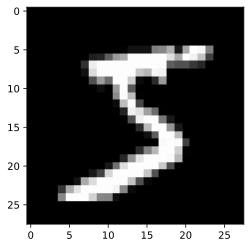

time: 956 ms (started: 2021-08-26 16:18:00 +08:00)


In [18]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

# 具有列表/字典输入或嵌套输入的 RNN
嵌套结构允许实现者在单个时间步长内包含更多信息。 例如，视频帧可以同时具有音频和视频输入。 这种情况下的数据形状可能是：

[batch, timestep, {"video": [height, width, channel], "audio": [频率]}]

在另一个示例中，手写数据可以同时具有笔当前位置的坐标 x 和 y，以及压力信息。 所以数据表示可以是：

[批次，时间步长，{“位置”：[x，y]，“压力”：[力]}]

以下代码提供了如何构建接受此类结构化输入的自定义 RNN 单元的示例。

## 定义支持嵌套输入/输出的自定义单元格
有关编写自己的层的详细信息，请参阅通过子类创建新层和模型。

In [19]:
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # 期望 input_shape 包含 2 个项目，[(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # 输入应该在 [(batch, input_1), (batch, input_2, input_3)]
        # 状态应该是 [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}

time: 1.11 ms (started: 2021-08-26 16:21:12 +08:00)


## 构建具有嵌套输入/输出的 RNN 模型
让我们构建一个使用 keras.layers.RNN 层和我们刚刚定义的自定义单元格的 Keras 模型。

In [20]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

time: 201 ms (started: 2021-08-26 16:22:19 +08:00)


## 使用随机生成的数据训练模型
由于此模型没有好的候选数据集，我们使用随机 Numpy 数据进行演示。

In [22]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

10/10 [==============================] - 2s 42ms/step - loss: 0.7565 - rnn_1_loss: 0.2793 - rnn_1_1_loss: 0.4773 - rnn_1_accuracy: 0.0828 - rnn_1_1_accuracy: 0.0319


time: 2.8 s (started: 2021-08-26 16:23:12 +08:00)


使用`Keras keras.layers.RNN` 层，您只需为序列中的各个步骤定义数学逻辑，`keras.layers.RNN` 层将为您处理序列迭代。 这是一种快速构建新型 RNN（例如 LSTM 变体）原型的非常强大的方法。

有关更多详细信息，请访问 API 文档。